# Mountain Car
### Pierpaolo Spaziani - 0316331

In [305]:
import gym
import numpy as np
import imageio
import random
import math
import matplotlib.pyplot as plt

In [306]:
# In the gym library there is a deprecation about NumPy
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning, module="gym.utils.passive_env_checker")

### Parameters

In [307]:
LEARNING_RATE = 1
DISCOUNT = 0.95
EPSILON = 0.0

EPISODES = 1000

DISCRETE_SIZE = 20

RENDER = False
SHOW_EVERY = 2

In [308]:
if RENDER:
    env = gym.make("MountainCar-v0", render_mode="rgb_array_list")
else:
    env = gym.make("MountainCar-v0")

### Discretization
In the presence of *continuous states* it is convenient to **discretize** for several reasons:
- Limit the state space
- Memory management
- Faster training
- Generalization

In [309]:
chunk_size = (env.observation_space.high - env.observation_space.low) / DISCRETE_SIZE

def get_discrete_state(state):
    discrete_state = (state - env.observation_space.low) / chunk_size
    return tuple(discrete_state.astype(int))

### Decay functions

Implementation of decay functions used for ***Learning Rate*** and ***Epsilon***:
- *linear decay*
- *exponential decay*

In [310]:
def decay(episode, type, actual_value, max_value):
    if type == 'linear':
        actual_value = linear_decay(actual_value, max_value)
    elif type == 'exponential':
        actual_value = exponential_decay(episode, max_value)
    return actual_value

def linear_decay(actual_value, max_value):
    decay_rate = max_value / (EPISODES/2)
    new_value = actual_value - decay_rate
    return max(0, new_value)

def exponential_decay(episode, max_value):
    alpha = -math.log(0.01) / (EPISODES)
    new_value = max_value * math.exp(-alpha * episode)
    return max(0, new_value)

### ε-Greedy

Implementation of the **ε-Greedy** policy for *exploration-exploitation trade-off* with 2 types of decay:
- *linear decay*
- *exponential decay*

In [311]:
def epsilon_greedy(epsilon):
    if random.uniform(0, 1) < epsilon:
        # takes a random action
        return random.choice(range(env.action_space.n))
    else:
        # takes the "best" action
        return -1

### Q-Learning

Implementation of the solution based on **Q-Learning**:

In [312]:
def q_learning(learning_rate_decay, epsilon_decay):
    q_table = np.zeros((DISCRETE_SIZE, DISCRETE_SIZE, env.action_space.n))
    learning_rate = LEARNING_RATE
    epsilon = EPSILON
    howmany = 0
    q_learning_list = []
    learning_rate_hystory = []
    epsilon_hystory = []
    for episode in range(EPISODES):
        print("Episode:", episode, end="\r")
        
        env.reset()
    
        if (RENDER and episode % SHOW_EVERY == 0):
            render = True
        else:
            render = False
    
        discrete_state = get_discrete_state(env.state)
        
        learning_rate = decay(episode, learning_rate_decay, learning_rate, LEARNING_RATE)
        epsilon = decay(episode, epsilon_decay, epsilon, EPSILON)
        learning_rate_hystory.append(learning_rate)
        epsilon_hystory.append(epsilon)
        
        done = False
        while not done:
            
            # select an action following the epsilon-greedy policy
            action = epsilon_greedy(epsilon)
            if action < 0:
                action = np.argmax(q_table[discrete_state])
            observation, reward, terminated, truncated, info = env.step(action)
            new_discrete_state = get_discrete_state(observation)
        
            done = terminated or truncated
            if not done:
                max_future_q = np.max(q_table[new_discrete_state])
                current_q = q_table[discrete_state + (action, )]
                new_q = current_q + learning_rate * (reward + DISCOUNT * max_future_q - current_q)
                q_table[discrete_state + (action, )] = new_q
            elif terminated:
                howmany = howmany + 1
                #print(f"Congratulation! We reached to the goal! Episode: {episode}")
                #q_table[discrete_state + (action, )] = 0 # ----------------------------------------> SECONDO ME QUESTO VA TOLTO
    
            discrete_state = new_discrete_state
            
        q_learning_list.append(howmany)
            
        if render:
            imageio.mimsave(f'./gifs/{episode}.gif', env.render(), fps=30)
    
    env.close()
    return q_learning_list, learning_rate_hystory, epsilon_hystory

In [313]:
def SARSA(learning_rate_decay, epsilon_decay):
    q_table = np.zeros((DISCRETE_SIZE, DISCRETE_SIZE, env.action_space.n))
    learning_rate = LEARNING_RATE
    epsilon = EPSILON
    howmany = 0
    sarsa_list = []
    learning_rate_hystory = []
    epsilon_hystory = []
    for episode in range(EPISODES):
        print("Episode:", episode, end="\r")
        
        env.reset()
    
        if (RENDER and episode % SHOW_EVERY == 0):
            render = True
        else:
            render = False
    
        discrete_state = get_discrete_state(env.state)

        learning_rate = decay(episode, learning_rate_decay, learning_rate, LEARNING_RATE)
        epsilon = decay(episode, epsilon_decay, epsilon, EPSILON)
        learning_rate_hystory.append(learning_rate)
        epsilon_hystory.append(epsilon)
        
        # select an action following the epsilon-greedy policy
        action = epsilon_greedy(epsilon)
        if action < 0:
            action = np.argmax(q_table[discrete_state])
        
        done = False
        while not done:
                
            observation, reward, terminated, truncated, info = env.step(action)
            new_discrete_state = get_discrete_state(observation)

            # Select a new action following the epsilon-greedy policy
            new_action = epsilon_greedy(epsilon)
            if new_action < 0:
                new_action = np.argmax(q_table[new_discrete_state])
        
            done = terminated or truncated
            if not done:                
                new_q = q_table[new_discrete_state + (new_action, )]
                current_q = q_table[discrete_state + (action, )]
                updated_q = current_q + learning_rate * (reward + DISCOUNT * new_q - current_q)
                q_table[discrete_state + (action, )] = updated_q
            elif terminated:
                howmany = howmany + 1
                #print(f"Congratulation! We reached to the goal! Episode: {episode}")
    
            discrete_state = new_discrete_state
            action = new_action
            
        sarsa_list.append(howmany)
            
        if render:
            imageio.mimsave(f'./gifs/{episode}.gif', env.render(), fps=30)
    
    env.close()
    return sarsa_list, learning_rate_hystory, epsilon_hystory

## Simulation

The following parameters are common among algorithm simulations:

In [318]:
# constant linear exponential
learning_rate_decay = 'exponential'
epsilon_decay = 'linear'

In [319]:
q_learning_list, q_learning_learning_rate, q_learning_epsilon_hystory = q_learning(learning_rate_decay, epsilon_decay)
print("Ci sono stati", q_learning_list[-1], "successi!")

Ci sono stati 365 successi!


In [320]:
sarsa_list, sarsa_learning_rate, sarsa_epsilon_hystory = SARSA(learning_rate_decay, epsilon_decay)
print("Ci sono stati", sarsa_list[-1], "successi!")

Ci sono stati 485 successi!


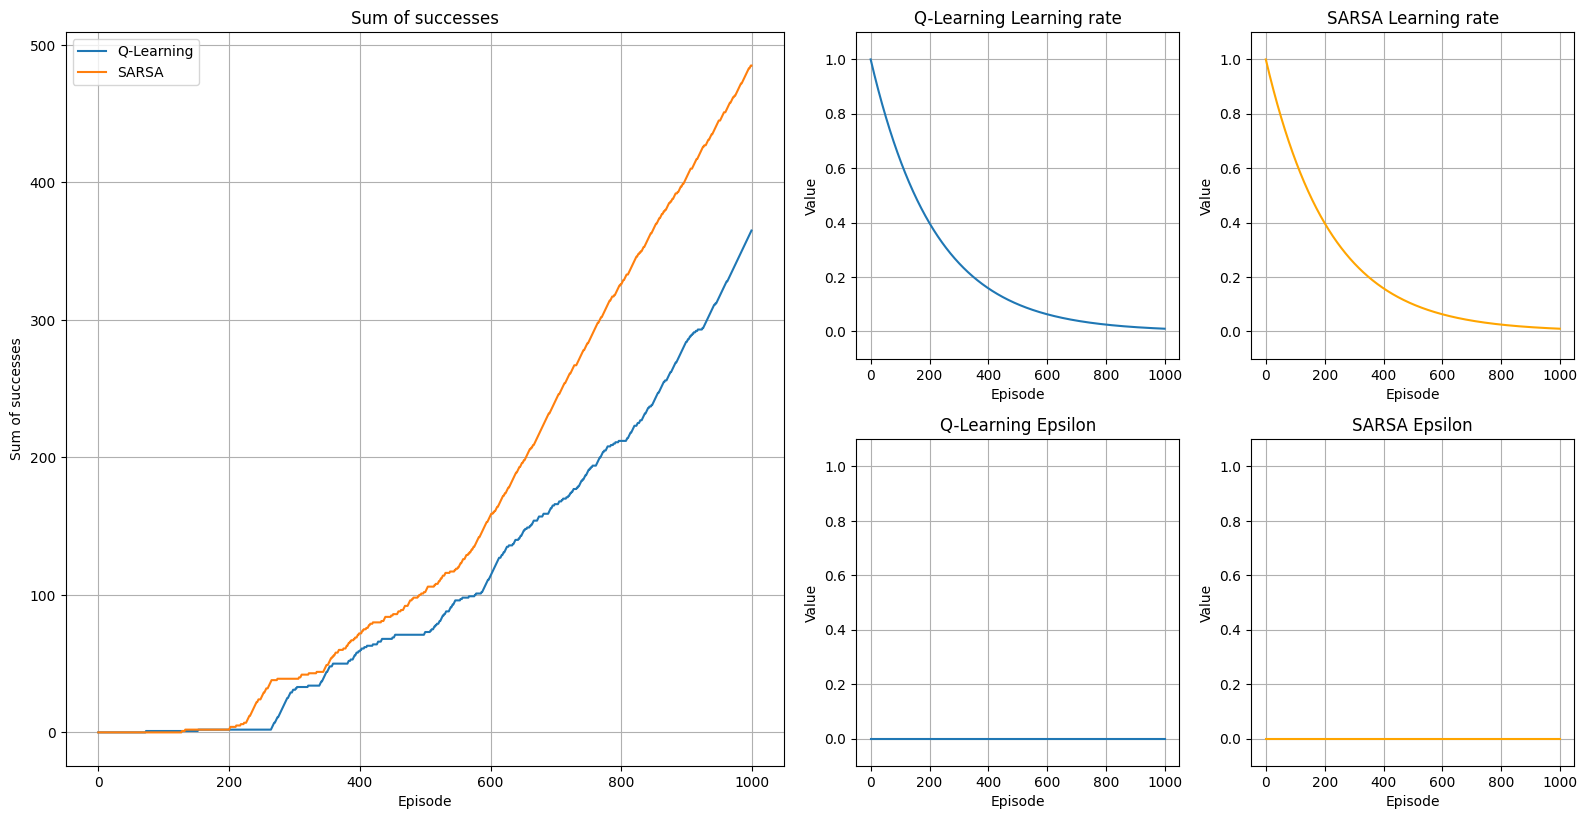

In [321]:
# Creare una figura con una larghezza desiderata
plt.figure(figsize=(16, 16))  # Puoi regolare i valori di larghezza e altezza secondo le tue esigenze

# Creare il primo subplot accanto agli altri quattro
plt.subplot2grid((4, 4), (0, 0), rowspan=2, colspan=2)
plt.plot(q_learning_list, label='Q-Learning')
plt.plot(sarsa_list, label='SARSA')
plt.xlabel('Episode')
plt.ylabel('Sum of successes')
plt.title('Sum of successes')
plt.legend()
plt.grid(True)

# Creare il secondo subplot
plt.subplot2grid((4, 4), (0, 2), rowspan=1, colspan=1)
plt.plot(q_learning_learning_rate)
plt.ylim(-0.1, 1.1)
plt.xlabel('Episode')
plt.ylabel('Value')
plt.title('Q-Learning Learning rate')
plt.grid(True)

# Creare il terzo subplot
plt.subplot2grid((4, 4), (0, 3), rowspan=1, colspan=1)
plt.plot(sarsa_learning_rate, color='orange')
plt.ylim(-0.1, 1.1)
plt.xlabel('Episode')
plt.ylabel('Value')
plt.title('SARSA Learning rate')
plt.grid(True)

# Creare il quarto subplot
plt.subplot2grid((4, 4), (1, 2), rowspan=1, colspan=1)
plt.plot(q_learning_epsilon_hystory)
plt.ylim(-0.1, 1.1)
plt.xlabel('Episode')
plt.ylabel('Value')
plt.title('Q-Learning Epsilon')
plt.grid(True)

# Creare il quinto subplot
plt.subplot2grid((4, 4), (1, 3), rowspan=1, colspan=1)
plt.plot(sarsa_epsilon_hystory, color='orange')
plt.ylim(-0.1, 1.1)
plt.xlabel('Episode')
plt.ylabel('Value')
plt.title('SARSA Epsilon')
plt.grid(True)

# Regolare il layout per evitare sovrapposizioni
plt.tight_layout()

# Mostrare i grafici
plt.show()
